# Batch (parallel) Demand Forecasting using Prophet, ARIMA, and Ray Tune

**Batch training** and tuning are common tasks in machine learning use-cases. They require training simple models, on data batches, typcially corresponding to different locations, products, etc. Batch training can take less time to process all the data at once, but only if those batches can run in parallel!

This notebook showcases how to conduct batch training using forecast algorithms [Prophet](https://github.com/facebook/prophet) and [ARIMA](https://github.com/Nixtla/statsforecast). **Prophet** is a popular open-source library developed by Facebook and designed for automatic forecasting of univariate time series data. **ARIMA** is an older, well-known algorithm for forecasting univariate time series at less fine-grained detail than Prophet.

![Batch training diagram](../../data/examples/images/batch-training.svg)

For the data, we will use the [NYC Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This popular tabular dataset contains historical taxi pickups by timestamp and location in NYC.

For the training, we will train a separate forecasting model to predict #pickups at each location in NYC at daily level for the next 28 days. Specifically, we will use the `pickup_location_id` column in the dataset to group the dataset into data batches. Then we will conduct an experiment for each location, to find the best either Prophet or ARIMA model, per location.

# Contents

In this this tutorial, you will learn about:
 1. [Define how to load and prepare Parquet data](#prepare_data)
 2. [Define your Ray Tune Search Space and Search Algorithm](#define_search_space2)
 3. [Define a Trainable (callable) function](#define_trainable2)
 4. [Run batch training on Ray Tune](#run_tune_search2)
 5. [Load a model from checkpoint and perform inference](#load_checkpoint2)


# Walkthrough

```{tip}
Prerequisite for this notebook: Read the [Key Concepts](https://docs.ray.io/en/latest/tune/key-concepts.html) page for Ray Tune.
```

Let us start by importing a few required libraries, including open-source [Ray](https://github.com/ray-project/ray) itself!

In [1]:
import os

print(f"Number of CPUs in this system: {os.cpu_count()}")
from typing import Tuple, List, Union, Optional, Callable
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np

print(f"numpy: {np.__version__}")
import matplotlib.pyplot as plt

%matplotlib inline
import scipy

print(f"scipy: {scipy.__version__}")
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds

print(f"pyarrow: {pyarrow.__version__}")

Number of CPUs in this system: 8
numpy: 1.23.5
scipy: 1.9.3
pyarrow: 10.0.0


In [2]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

Python version:,3.8.13
Ray version:,2.1.0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard


In [3]:
print(ray.cluster_resources())

{'object_store_memory': 27553303756.0, 'CPU': 24.0, 'node:172.31.172.139': 1.0, 'memory': 66320780494.0, 'node:172.31.226.150': 1.0}


In [4]:
# import forecasting libraries
import prophet
from prophet import Prophet

print(f"prophet: {prophet.__version__}")

import statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

print(f"statsforecast: {statsforecast.__version__}")

# import ray libraries
from ray import air, tune
from ray.air import session
from ray.air.checkpoint import Checkpoint

prophet: 1.1.1
statsforecast: 1.3.1


In [5]:
# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False


def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)


# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = True

## Define how to load and prepare Parquet data <a class="anchor" id="load_data"></a>

First, we need to load some data. Since the NYC Taxi dataset is fairly large, we will filter files first into a PyArrow dataset. And then in the next cell after, we will filter the data on read into a PyArrow table and convert that to a pandas dataframe.

```{tip}
Use PyArrow dataset and table for reading or writing large parquet files, since its native multithreaded C++ adpater is faster than pandas read_parquet, even using engine=pyarrow.
```

In [6]:
# Define some global variables.
TARGET = "trip_duration"
FORECAST_LENGTH = 28
MAX_DATE = datetime(2019, 6, 30)
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
    partitioning=["year", "month"],
)
s3_files = [f"s3://anonymous@{file}" for file in s3_partitions.files]

# Obtain all location IDs
all_location_ids = (
    pq.read_table(s3_files[0], columns=["pickup_location_id"])[
        "pickup_location_id"
    ]
    .unique()
    .to_pylist()
)
# drop [264, 265]
all_location_ids.remove(264)
all_location_ids.remove(265)

# Use smoke testing or not.
starting_idx = -2 if SMOKE_TEST else 0
sample_locations = [141, 229, 173] if SMOKE_TEST else all_location_ids

# Display what data will be used.
s3_files = s3_files[starting_idx:]
print(f"NYC Taxi using {len(s3_files)} file(s)!")
print(f"s3_files: {s3_files}")
print(f"Locations: {sample_locations}")

NYC Taxi using 2 file(s)!
s3_files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/05/data.parquet/359c21b3e28f40328e68cf66f7ba40e2_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/06/data.parquet/ab5b9d2b8cc94be19346e260b543ec35_000000.parquet']
Locations: [141, 229, 173]


In [7]:
# Function to read a pyarrow.Table object using pyarrow parquet
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:

    # parse out min expected date
    part_zero = "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/"
    split_text = file.split(part_zero)[1]
    min_year = split_text.split("/")[0]
    min_month = split_text.split("/")[1]
    string_date = min_year + "-" + min_month + "-" + "01" + " 00:00:00"
    min_date = datetime.strptime(string_date, "%Y-%m-%d %H:%M:%S")

    df = pq.read_table(
        file,
        filters=[
            ("pickup_at", ">", min_date),
            ("pickup_at", "<=", MAX_DATE),
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]),
            ("pickup_location_id", "=", sample_id),
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df


# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()

    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]

    # Prophet requires timstamp is 'ds' and target_value name is 'y'
    # Prophet requires at least 2 data points per timestamp
    # StatsForecast requires location name is 'unique_id'

    # add year_month_day and concat into a unique column to use as groupby key
    df["ds"] = df["pickup_at"].dt.to_period("D").dt.to_timestamp()
    df["loc_year_month_day"] = (
        df["pickup_location_id"].astype(str)
        + "_"
        + df["pickup_at"].dt.year.astype(str)
        + "_"
        + df["pickup_at"].dt.month.astype(str)
        + "_"
        + df["pickup_at"].dt.day.astype(str)
    )
    # add target_value quantity for groupby count later
    df["y"] = 1
    # rename pickup_location_id to unique_id
    df.rename(columns={"pickup_location_id": "unique_id"}, inplace=True)
    # drop unnecessary columns
    df.drop(
        [
            "dropoff_at",
            "pickup_at",
            "dropoff_location_id",
            "fare_amount",
            "passenger_count",
            "trip_distance",
            "trip_duration",
        ],
        axis=1,
        inplace=True,
    )

    # groupby aggregregate
    g = df.groupby("loc_year_month_day").agg(
        {"unique_id": min, "ds": min, "y": sum}
    )
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g["y"] > 2].copy()

    # Drop groupby variable since we do not need it anymore
    g.reset_index(inplace=True)
    g.drop(["loc_year_month_day"], axis=1, inplace=True)

    return g

## Define your Ray Tune Search Space and Search Algorithm <a class="anchor" id="define_search_space"></a>

In this notebook, we will use Ray Tune to run parallel training jobs per pickup location. The training jobs will be defined using a search space and simple grid search. Depending on your need, fancier search spaces and search algorithms are possible with Tune.

**First, define a search space of experiment trials to run.**
> The typical use case for Tune search spaces are for hyperparameter tuning. In our case, we are defining a Tune search space in a way to allow for training jobs to be conducted automatically. Each training job will run on a different data partition (taxi pickup location) and use a different algorithm.

**Next, define a search algorithm.**  

```{tip}
Common search algorithms include grid search, random search, and Bayesian optimization. For more details, see [Working with Tune Search Spaces](https://docs.ray.io/en/master/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial). Deciding the best combination of search space and search algorithm is part of the art of being a Data Scientist and depends on the data, algorithm, and problem being solved.
```

Ray Tune will use the search space and search algorithm to generate multiple configurations, each of which will be evaluated in a separate Trial on a Ray Cluster. Ray Tune will take care of orchestrating those Trials automatically. Specifically, Ray Tune will pass a config dictionary to each partition and make a Trainable function call.

**Below, we define our search space consists of:**
- Different algorithms, either:
  - Prophet with [multiplicative or additive](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) seasonal effects 
  - AutoARIMA.
- Some or all NYC taxi drop-off locations.

For Tune search algorithm, we want to run *grid search*, meaning we want to run an experiment for every possible combination in the search space.  What this means is every algorithm will be applied to every NYC Taxi drop-off location.

In [15]:
# 1. Define a search space.
search_space = {
    "algorithm": tune.grid_search(
        ["prophet_additive", "prophet_multiplicative", "arima"]
    ),
    "location": tune.grid_search(sample_locations),
}

## Define a Trainable (callable) function <a class="anchor" id="define_trainable"></a>

📈 Typically when you are running Data Science experiments, you want to be able to keep track of summary metrics for each trial, so you can decide at the end which trials were best. That way, you can decide which model to deploy.

🇫 Next, we define a trainable function in order to train and evaluate a Prophet model on a data partition. This function will be called in parallel by every Tune trial. Inside this trainable function, we will:
- Add detailed metrics we want to report (each model's loss or error). 
- Checkpoint each model for easy deployment later.

📖 **The metrics defined inside the trainable function will appear in the Ray Tune experiment summary table.**
```{tip}
Ray Tune has two ways of defining a trainable, namely the [Function API](https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs) and the Class API. Both are valid ways of defining a trainable, but *the Function API is generally recommended*.
```

**In the cell below, we define a "Trainable" function called `train_model()`**.
- The input is a config dictionary argument. 
- The output can be a simple dictionary of metrics which will be reported back to Tune.
- We will [checkpoint](https://docs.ray.io/en/master/ray-air/key-concepts.html#checkpoints) save each model in addition to reporting each trial's metrics.
- Since we are using **grid search**, this means `train_model()` will be run *in parallel for every permutation* in the Tune search space!

In [16]:
def evaluate_model_prophet(
    model: "prophet.forecaster.Prophet",
) -> Tuple[float, pd.DataFrame]:

    # Inference model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(
        periods=FORECAST_LENGTH, freq="D"
    )
    future = model.predict(future_dates)

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["trend"])
    error = np.mean(temp["forecast_error"])

    return error, future


def evaluate_model_statsforecast(
    model: "statsforecast.models.AutoARIMA", test_df: pd.DataFrame
) -> Tuple[float, pd.DataFrame]:

    # Inference model using test data.
    forecast = model.forecast(FORECAST_LENGTH + 1).reset_index()
    forecast.set_index(["ds"], inplace=True)
    test_df.set_index("ds", inplace=True)
    future = pd.concat([test_df, forecast[["AutoARIMA"]]], axis=1)
    future.dropna(inplace=True)
    future.columns = ["unique_id", "trend", "yhat"]

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["trend"])
    error = np.mean(temp["forecast_error"])

    return error, future


# 2. Define a custom train function
def train_model(config: dict) -> None:

    # Get Tune parameters
    sample_location_id = config["location"]
    model_type = config["algorithm"]

    # Define Prophet model with 75% confidence interval
    if model_type == "prophet_additive":
        model = Prophet(interval_width=0.75, seasonality_mode="additive")
    elif model_type == "prophet_multiplicative":
        model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")
    # Define ARIMA model with daily frequency which implies seasonality = 7
    elif model_type == "arima":
        model = [AutoARIMA(season_length=7, approximation=True)]

    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]
    df_raw = pd.concat(df_list, ignore_index=True)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(
            f"Location {sample_location_id} has only {df_raw.shape[0]} rows"
        )
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        return None
    else:
        df.sort_values(by="ds", inplace=True)

    # Train model.
    if model_type == "arima":

        # split data into train, test.
        train_end = df.ds.max() - timedelta(days=FORECAST_LENGTH+1)
        train_df = df.loc[(df.ds <= train_end), :].copy()
        test_df = df.iloc[-FORECAST_LENGTH:, :].copy()

        # fit AutoARIMA.
        model = StatsForecast(df=train_df, models=model, freq="D")

        # Inference model and evaluate error.
        error, future = evaluate_model_statsforecast(model, test_df)

    else:  # model type is Prophet

        # fit Prophet.
        model = model.fit(df[["ds", "y"]])

        # Inference model and evaluate error.
        error, future = evaluate_model_prophet(model)

    # Define a model checkpoint using AIR API.
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = ray.air.checkpoint.Checkpoint.from_dict(
        {
            "model": model,
            "forecast_df": future,
            "location_id": sample_location_id,
        }
    )

    # Save checkpoint and report back metrics, using ray.air.session.report()
    # The metrics you specify here will appear in Tune summary table.
    # They will also be recorded in Tune results under `metrics`.
    metrics = dict(error=error)
    session.report(metrics, checkpoint=checkpoint)

## Run batch training on Ray Tune <a class="anchor" id="run_tune_search"></a>


**Now we are ready to kick off a Ray Tune experiment!**  

Recall what we are doing, high level, is training several different models per pickup location. We are using Ray Tune so we can run all these trials in parallel on a Ray cluster.  At the end, we will inspect the results of the experiment and deploy only the best model per pickup location.

**In the cell below, we use AIR configs and run the experiment using `tuner.fit()`.** 

Tune will report on experiment status, and after the experiment finishes, you can inspect the results. 

- In the cell below, we use the default resources config which is 1 CPU core for each task.  For more information about configuring resource allocations, see [A Guide To Parallelism and Resources](https://docs.ray.io/en/master/tune/tutorials/tune-resources.html#tune-parallelism). 

- In the AIR config below, we have specified a local directory `my_Tune_logs` for logging instead of the default `~/ray_results` directory. Giving your logs a project name makes them easier to find. Also giving a relative path, means you can see your logs inside the Jupyter browser. Learn more about logging Tune results at [How to configure logging in Tune](https://docs.ray.io/en/master/tune/tutorials/tune-output.html#tune-logging).

- Tune can [retry failed experiments automatically](https://docs.ray.io/en/master/tune/tutorials/tune-stopping.html#tune-stopping-guide), as well as entire experiments. This is necessary in case a node on your remote cluster fails (when running on a cloud such as AWS or GCP).

💡 Right-click on the cell below and choose "Enable Scrolling for Outputs"! This will make it easier to view, since model training output can be very long!

**In the output below and in the Ray Dashboard, you can see that 771 models, using 18 NYC Taxi S3 files dating from 2018/01 to 2019/06 (split into partitions approx 1GiB each), were simultaneously trained on a 7-node AWS cluster of [m5.4xlarges](https://aws.amazon.com/ec2/instance-types/m5/), within 40 minutes.**

In [17]:
# By default, Tune reserves 1 CPU core per task.
# # 3. Customize resources per trial, here we set 1 CPU each.
# train_model = tune.with_resources(train_model, {"cpu": 1})

# Define a tuner object using Ray AIR Tuner API
tuner = tune.Tuner(
    train_model,
    param_space=search_space,
    run_config=air.RunConfig(
        # redirect logs to relative path instead of default ~/ray_results/
        local_dir="my_Tune_logs",
        name="batch_tuning",
        # Set Ray Tune verbosity. Print summary table only with levels 2 or 3.
        verbose=2,
    ),
)

# 4. Run the experiment with Ray Tune
start = time.time()
results = tuner.fit()
total_time_taken = time.time() - start

# Print some training stats
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {total_time_taken:.2f} seconds")
best_result = results.get_best_result(metric="error", mode="min").config
print(f"Best result: {best_result}")

Trial name,error,should_checkpoint
train_model_591c9_00000,502.849,True
train_model_591c9_00001,483.067,True
train_model_591c9_00002,577.399,True
train_model_591c9_00003,539.389,True
train_model_591c9_00004,529.743,True
train_model_591c9_00005,3627.31,True
train_model_591c9_00006,2.55585,True
train_model_591c9_00007,2.52897,True
train_model_591c9_00008,3.05726,True


Total number of models: 9
TOTAL TIME TAKEN: 36.04 seconds
Best result: {'algorithm': 'prophet_multiplicative', 'location': 173}


<br>

**After the Tune experiment has run, select the best model per pickup location.**

We can assemble the Tune results ([ResultGrid object](https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html)) into a pandas dataframe, then sort by minimum error, to select the best model per pickup location.

In [18]:
# get a list of training loss errors
errors = [i.metrics.get("error", 10000.0) for i in results]

# get a list of checkpoints
checkpoints = [i.checkpoint for i in results]

# get a list of locations
locations = [i.config["location"] for i in results]

# get a list of model params
algorithm = [i.config["algorithm"] for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(
    zip(locations, errors, algorithm, checkpoints),
    columns=["location_id", "error", "algorithm", "checkpoint"],
)
print(results_df.dtypes)
results_df.head(8)

location_id      int64
error          float64
algorithm       object
checkpoint      object
dtype: object


,location_id,error,algorithm,checkpoint
0,141,502.848601,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
1,141,483.067259,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...
2,141,577.398955,arima,Checkpoint(local_path=/home/ray/christy-air/my...
3,229,539.389339,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
4,229,529.743081,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...
5,229,3627.310438,arima,Checkpoint(local_path=/home/ray/christy-air/my...
6,173,2.555847,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/my...
7,173,2.528968,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...


In [19]:
# Keep only 1 model per location_id with minimum error
final_df = results_df.copy()
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby("location_id")["error"].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index("location_id", inplace=True, drop=True)
print(final_df.dtypes)
final_df

error         float64
algorithm      object
checkpoint     object
dtype: object


,error,algorithm,checkpoint
location_id,,,
173,2.528968,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...
141,483.067259,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...
229,529.743081,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...


In [20]:
final_df.describe(include="all")

,error,algorithm,checkpoint
count,3.000000,3,3
unique,NaN,1,3
top,NaN,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/my...
freq,NaN,3,1
mean,338.446436,NaN,NaN
std,291.847678,NaN,NaN
min,2.528968,NaN,NaN
25%,242.798113,NaN,NaN
50%,483.067259,NaN,NaN
75%,506.405170,NaN,NaN


In [21]:
final_df[["algorithm"]].value_counts(normalize=True)

algorithm             
prophet_multiplicative    1.0
dtype: float64

## Load a model from checkpoint and perform inference  <a class="anchor" id="load_checkpoint"></a>

```{tip}
[Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) make batch inference easy since they have internal logic to parallelize the inference.
```
  
Finally, we will restore the best and worst models from checkpoint, make predictions, and inspect the forecasts. Prophet includes a convenient plot library which displays actual data along with predictions and confidence intervals and future forecasts.

- We will restore a Prophet model directly from checkpoint, and demonstrate it can be used for inference.
- We will easily obtain AIR Checkpoint objects from the Tune results. 


checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 173, algorithm prophet_multiplicative, best error 2.528968219379467


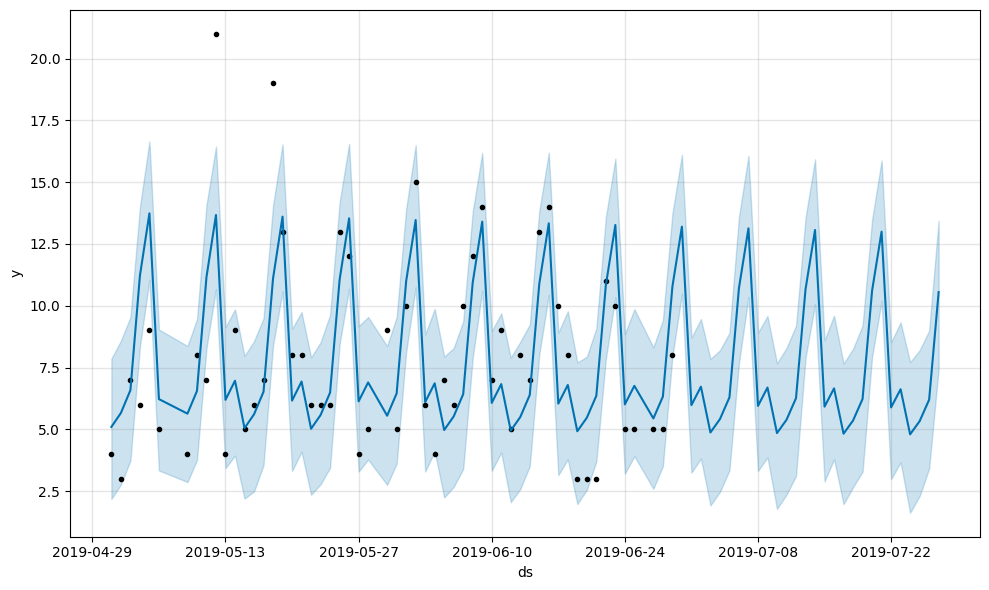

In [22]:
# Get the pickup location for the best model
sample_location_id = final_df.index[0]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_location_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Print location and error.
sample_error = final_df.loc[[sample_location_id]].error.values[0]
print(
    f"location {sample_location_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["trend", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 229, algorithm prophet_multiplicative, best error 529.7430808154045


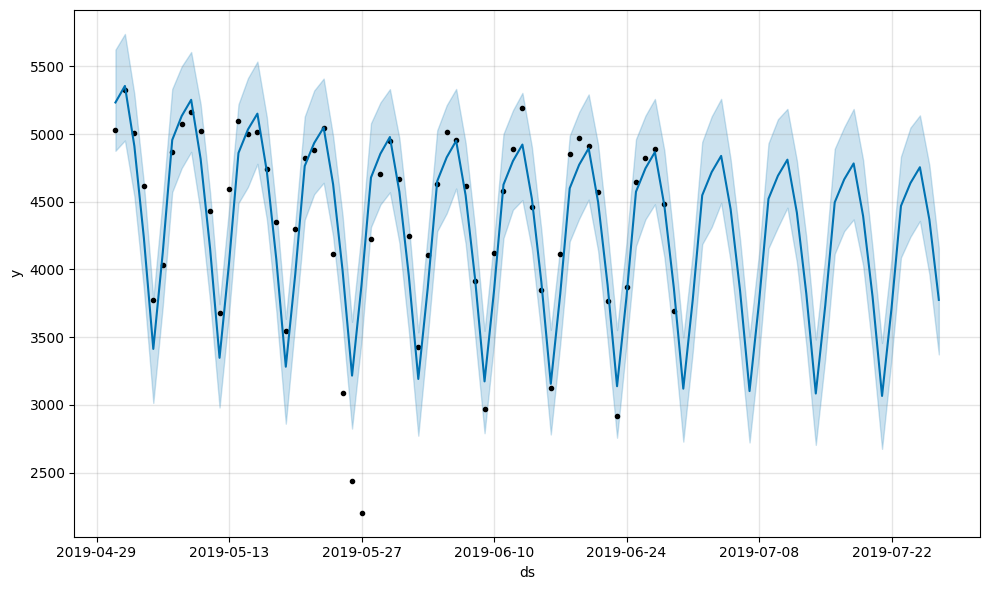

In [23]:
# Get the pickup location for the worst model
sample_location_id = final_df.index[len(final_df) - 1]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_location_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Print location and error.
sample_error = final_df.loc[[sample_location_id]].error.values[0]
print(
    f"location {sample_location_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["trend", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)